### Trying to solve Task 2 now!

Maybe take a look at [this](https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96) as it is a nice way to show how to handle preprocessing.

In [ ]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
trainFeatUrl = 'https://raw.githubusercontent.com/Toroto006/iml2021/main/task2/train_features.csv?token=AH44KNVEVSH3VTA527ZEDNLAP34PQ'
testFeatUrl = 'https://raw.githubusercontent.com/Toroto006/iml2021/main/task2/test_features.csv?token=AH44KNQTTC3NGV7XAHAG73DAP34PU'
trainLblUrl = 'https://raw.githubusercontent.com/Toroto006/iml2021/main/task2/train_labels.csv?token=AH44KNSBRPXVQOSQM6POTHDAP34PM'

trainFeatPD_raw = pd.read_csv(trainFeatUrl)
trainFeatPD_raw.head(1)

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,3,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33


In [ ]:
testFeatPD = pd.read_csv(testFeatUrl)
testFeatPD.head(1)

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,0,1,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
trainLblPD = pd.read_csv(trainLblUrl)
trainLblPD.head(2)

,pid,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5


First we notice the difference in times, hence change that

In [ ]:
np.sort(trainFeatPD_raw["Time"])[-50:]


array([ 31,  31,  31,  31,  32,  32,  32,  32,  32,  32,  33,  33,  33,
        33,  33,  34,  34,  34,  34,  34,  35,  35,  35,  36,  36,  37,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315])

The align_times does exactly that, as we have "the first 12 hours in ICU". This takes for 300000 entries already ~15 on colab though...

In [ ]:
def align_times():
  print(f"len of train {len(trainFeatPD_raw)}/12 = {len(trainFeatPD_raw)/12} i.e. len%12 == 0")
  assert len(trainFeatPD_raw)%12 == 0, "We do not have 12 hours for each patient!"

  trainFeatPD_raw.sort_values(["pid", "Time"], ascending=[True, True], inplace=True, ignore_index=True)
  for idx, _ in trainFeatPD_raw.iterrows():
    i = idx % 12 + 1
    trainFeatPD_raw.at[idx, 'Time'] = i

align_times()
trainFeatPD_raw.head(2)

len of train 227940/12 = 18995.0 i.e. len%12 == 0


,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,1,34.0,NaN,NaN,12.0,NaN,36.0,8.7,24.0,-2.0,16.0,NaN,NaN,6.3,NaN,45.0,NaN,NaN,NaN,NaN,NaN,84.0,1.2,3.8,61.0,NaN,NaN,100.0,NaN,114.0,24.6,94.0,NaN,NaN,142.0,7.33
1,1,2,34.0,NaN,NaN,NaN,NaN,36.0,NaN,NaN,-2.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,81.0,NaN,NaN,62.5,NaN,NaN,100.0,NaN,NaN,NaN,99.0,NaN,NaN,125.0,7.33


We have an incredible amount of NaN, hence we have to do some more preprocessing.  
Trying to follow [Working with Missing Data in Machine Learning](https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce)

In [ ]:
percentMiss = trainFeatPD_raw.isnull().sum()/len(trainFeatPD_raw)*100
print(f"Amount of NaNs for some per col in %:\n{percentMiss.tail()}")
print(f"That means we have max {np.sort(trainFeatPD_raw.isnull().sum()/len(trainFeatPD_raw)*100)[-1:]}% missing for some...")

Amount of NaNs for some per col in %:
Heartrate          12.201457
Bilirubin_total    97.663420
TroponinI          98.343424
ABPs               15.920856
pH                 89.012021
dtype: float64
That means we have max [99.68456611]% missing for some...


Our max age is 100.0 and min is 15.0.
Let's go with 10 bins for histogramm and KNN Imputer.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc6e88000d0>]],
      dtype=object)

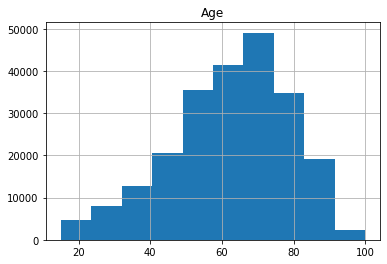

In [ ]:
print(f"Our max age is {trainFeatPD_raw['Age'].max()} and min is {trainFeatPD_raw['Age'].min()}.")
bins = 10
print(f"Let's go with {bins} bins for histogramm and KNN Imputer.")
trainFeatPD_raw.hist(column='Age', bins=bins)

Looks like we have quite a nice distribution for the age, hence doing some media imputation sounds doable, let's see.  
  
Two options are Simple or KNN. The simple imputer with mean or median does not look good on our data at all, as we have soo much missing data. On the other hand the KNN imputer does not make sense at all as our data is so far apart value wise and hence takes forever to converge, if at all.

In [ ]:
def impute(fromDF, KNN=False):
  if KNN:
    imputer = KNNImputer(n_neighbors=2) # Basically never converges
  imputer = SimpleImputer(missing_values=np.nan, strategy='median') # Looks really bad...
  trainFeatPD = pd.DataFrame(imputer.fit_transform(fromDF), columns=fromDF.columns)
  retrunt
trainFeatPD = impute(trainFeatPD_raw)
trainFeatPD.head(5)

AttributeError: ignored

Normalizing data necessary/bad/good?

In [ ]:
def normalize(fromDF, notIn=["pid", "Time", "Age"]):
  # first create scalar
  scaler = StandardScaler()
  # do it
  listNormalize = [lbl for lbl in fromDF.columns if lbl not in notIn]
  normalized = fromDF.copy()
  features = normalized[listNormalize]
  features = scaler.fit_transform(features.values)
  normalized[listNormalize] = features
  return normalized

trainFeatPD_normalized = normalize(trainFeatPD)
trainFeatPD_normalized.head(5)

,pid,Time,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,Fibrinogen,Phosphate,WBC,Creatinine,PaCO2,AST,FiO2,Platelets,SaO2,Glucose,ABPm,Magnesium,Potassium,ABPd,Calcium,Alkalinephos,SpO2,Bilirubin_direct,Chloride,Hct,Heartrate,Bilirubin_total,TroponinI,ABPs,pH
0,1,1,34.0,NaN,NaN,-0.558968,NaN,-0.973706,-0.929341,0.116246,-0.181444,-0.427643,NaN,NaN,-0.539088,NaN,0.434989,NaN,NaN,NaN,NaN,NaN,0.114300,-1.839007,-0.526339,-0.216573,NaN,NaN,0.838622,NaN,1.308314,-1.158184,0.537177,NaN,NaN,0.843444,-0.500542
1,1,2,34.0,NaN,NaN,NaN,NaN,-0.973706,NaN,NaN,-0.181444,-0.427643,NaN,NaN,NaN,NaN,NaN,NaN,-0.008224,NaN,NaN,NaN,-0.067829,NaN,NaN,-0.108815,NaN,NaN,0.838622,NaN,NaN,NaN,0.820569,NaN,NaN,0.113008,-0.500542
2,1,3,34.0,NaN,NaN,NaN,NaN,-0.973706,NaN,NaN,0.295591,-0.030582,NaN,NaN,NaN,NaN,0.211016,NaN,-0.012302,NaN,NaN,NaN,-0.492797,NaN,NaN,-0.360251,NaN,NaN,0.838622,NaN,NaN,NaN,0.423820,NaN,NaN,-0.531494,0.037220
3,1,4,34.0,NaN,NaN,NaN,NaN,0.168959,NaN,NaN,0.295591,-0.030582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.978475,NaN,NaN,-1.042720,NaN,NaN,0.838622,NaN,NaN,NaN,0.197107,NaN,NaN,-0.789295,0.037220
4,1,5,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.030582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.160604,-0.466868,NaN,-1.150478,NaN,NaN,0.838622,NaN,NaN,-1.539445,-0.199642,NaN,NaN,-0.961162,0.574982


In [ ]:
VITALS = ['LABEL_RRate', 'LABEL_ABPm', 'LABEL_SpO2', 'LABEL_Heartrate']
TESTS = ['LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST','LABEL_Alkalinephos',
         'LABEL_Bilirubin_total', 'LABEL_Lactate', 'LABEL_TroponinI', 'LABEL_SaO2',
         'LABEL_Bilirubin_direct', 'LABEL_EtCO2']

Now let's try to do a): ORDERING OF MEDICAL TEST  
Binary classification: 0 means that there will be no further tests of this kind ordered whereas 1 means that at least one is ordered in the remaining stay.

The corresponding columns containing the binary ground truth in train_labels are the TESTS array.

For the scoring function use [sklearn.metric.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [ ]:
# TODO train for a)
for lbl in TESTS:
  # this is the binary classifier for lbl
  Y = trainLblPD[["pid", lbl]]
  print(Y.head())
  X = trainFeatPD
  break

     pid  LABEL_BaseExcess
0      1               1.0
1     10               0.0
2    100               1.0
3   1000               0.0
4  10000               0.0


The following is modified from score_submission.py

In [ ]:
def get_score(df_true, df_submission):
    df_submission = df_submission.sort_values('pid')
    df_true = df_true.sort_values('pid')
    task1 = np.mean([metrics.roc_auc_score(df_true[entry], df_submission[entry]) for entry in TESTS])
    task2 = metrics.roc_auc_score(df_true['LABEL_Sepsis'], df_submission['LABEL_Sepsis'])
    task3 = np.mean([0.5 + 0.5 * np.maximum(0, metrics.r2_score(df_true[entry], df_submission[entry])) for entry in VITALS])
    score = np.mean([task1, task2, task3])
    print(f"total score is {score} where the individual scores are {task1}, {task2}, {task3}")
    return score

This is to output the final zip to be downloaded

In [ ]:
filename = "testOut.zip"
res.to_csv(filename, index=False, float_format='%.3f', compression='zip')

Run the score_submission to test if it works.

In [ ]:
# filename = 'sample.csv'
df_submission = pd.read_csv(filename)

# generate a baseline based on sample.zip
df_true = pd.read_csv(filename)
for label in TESTS + ['LABEL_Sepsis']:
    # round classification labels
    df_true[label] = np.around(df_true[label].values)

get_score(df_true, df_submission)